# Kernel density weighted PCA

In this notebook we reproduce results from [1] using a synthetic data set to demonstrate the usage of functions in the [`kernel_density.py`](https://gitlab.multiscale.utah.edu/common/PCA-python/blob/regression/PCA/kernel_methods/kernel_density.py) module.

> **References:**
> 
> [1] [Coussement, A., Gicquel, O., & Parente, A. (2012). Kernel density weighted principal component analysis of combustion processes. Combustion and flame, 159(9), 2844-2855.](https://www.sciencedirect.com/science/article/abs/pii/S001021801200123X)

In [1]:
import numpy as np
import pandas as pd
import random
from math import pi
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.decomposition import PCA
import PCA.clustering as cl
import PCA.regression.training_data_generation as tdg
import PCA.kernel_methods.kernel_density as kernd
import plotting.manifolds
from sklearn.preprocessing import StandardScaler

rcParams['font.size'] = 16
rcParams['grid.alpha'] = 0.5
rcParams['figure.figsize'] = 11, 6
rcParams["font.family"] = "serif"
rcParams["font.serif"] = "Charter"

Generate synthetic data set from [1]:

In [2]:
# Generate synthetic data set using formulas (14)-(16) from [1]:
n_pts = 2021
x1 = np.zeros((n_pts,1))
x2 = np.zeros((n_pts,1))
idx = np.zeros((n_pts,1))

for i in range(0,n_pts):
    
    R = random.random()
    
    if i <= 999:
        
        x1[i] = -1 + 20*R
        x2[i] = 5*x1[i] + 100*R
        idx[i] = 0
        
    if i >= 1000 and i <= 1020:
        
        x1[i] = 420 + 8*(i+1 - 1001)
        x2[i] = 5000/200 * (x1[i] - 400) + 500*R
        idx[i] = 1
    
    if i >= 1021 and i <= 2020:
        
        x1[i] = 1000 + 20*R
        x2[i] = 5*x1[i] + 100*R
        idx[i] = 2
        
idx = idx.astype(int)

Plot the synthetic data set

Text(0, 0.5, '$x_2$')

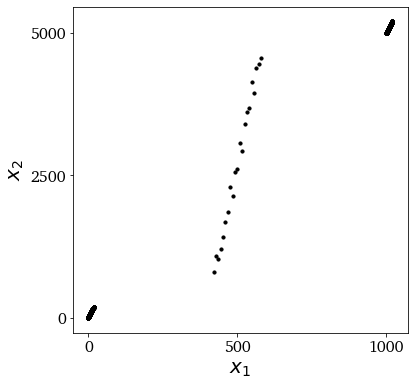

In [3]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(x1,x2, c='k', s=10)
plt.xticks([0, 500, 1000])
plt.yticks([0, 2500, 5000])
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

## Standard PCA

In [4]:
Dataset = np.column_stack((x1, x2))

# Z-scores scaling:
scaler = StandardScaler()
Dataset_scaled = scaler.fit_transform(Dataset)
Dataset_mean = scaler.mean_
Dataset_scale = scaler.scale_

# Perform PCA
q = 1

pca = PCA()
pca.fit(Dataset_scaled)
scores = pca.transform(Dataset_scaled)
PCs = pca.components_

Dataset_projected = np.dot(Dataset_scaled, PCs[:q,:].T)
Dataset_approx = np.dot(Dataset_projected[:,:q], PCs[:q,:]) * Dataset_scale + Dataset_mean

Text(0, 0.5, 'Approximated $x_2$')

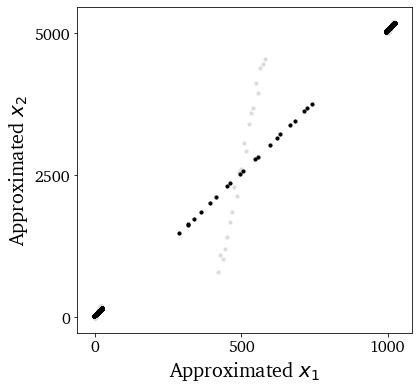

In [5]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(x1,x2, c='gainsboro', s=10)
plt.scatter(Dataset_approx[:,0],Dataset_approx[:,1], c='k', s=10)
plt.xticks([0, 500, 1000])
plt.yticks([0, 2500, 5000])
plt.xlabel('Approximated $x_1$', fontsize=20)
plt.ylabel('Approximated $x_2$', fontsize=20)

Parity plots:

Text(0, 0.5, 'Recovered $x_2$')

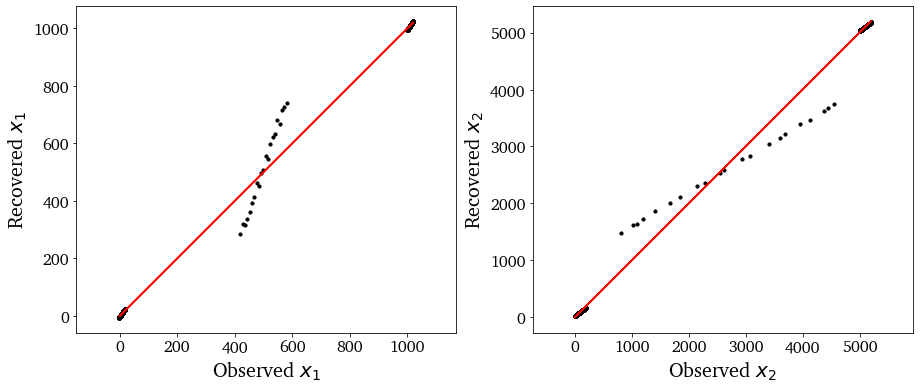

In [6]:
fig = plt.figure(figsize=(15, 6))

figureSubplot = plt.subplot(1,2,1)
plt.scatter(x1,Dataset_approx[:,0], c='k', s=10)
plt.plot(x1, x1, c='r')
plt.axis('equal')
plt.xlabel('Observed $x_1$', fontsize=20)
plt.ylabel('Recovered $x_1$', fontsize=20)

figureSubplot = plt.subplot(1,2,2)
plt.scatter(x2,Dataset_approx[:,1], c='k', s=10)
plt.plot(x2, x2, c='r')
plt.axis('equal')
plt.xlabel('Observed $x_2$', fontsize=20)
plt.ylabel('Recovered $x_2$', fontsize=20)

## Single-variable case

Compute the weights $W_c$:

In [7]:
%time W_c = kernd.single_variable_observation_weights(Dataset_scaled[:,0])

CPU times: user 15.3 s, sys: 407 ms, total: 15.7 s
Wall time: 15.8 s


Multiply every observation by a corresponding weight from $W_c$ (optionally one can create a diagonal matrix and take a dot product but for large data sets this matrix may become huge):

In [8]:
Dataset_weighted = np.multiply(Dataset_scaled, W_c)

Perform PCA on a kernel density weighted data set and approximate it with 1 PC:

In [9]:
# Perform PCA:
q = 1

pca = PCA()
pca.fit(Dataset_weighted)
scores = pca.transform(Dataset_weighted)
PCs_weighted = pca.components_

Dataset_weighted_projected = np.dot(Dataset_scaled, PCs_weighted[:q,:].T)
Dataset_weighted_approx = np.dot(Dataset_weighted_projected[:,:q], PCs_weighted[:q,:]) * Dataset_scale + Dataset_mean

Text(0, 0.5, 'Approximated $x_2$')

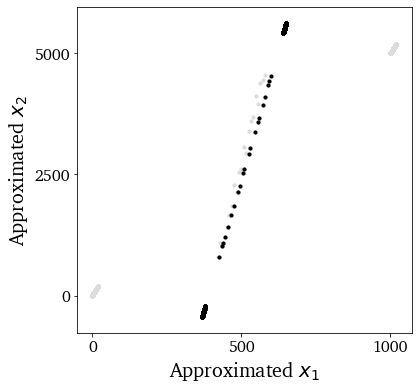

In [10]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(x1, x2, c='gainsboro', s=10)
plt.scatter(Dataset_weighted_approx[:,0],Dataset_weighted_approx[:,1], c='k', s=10)
plt.xticks([0, 500, 1000])
plt.yticks([0, 2500, 5000])
plt.xlabel('Approximated $x_1$', fontsize=20)
plt.ylabel('Approximated $x_2$', fontsize=20)

Parity plots:

Text(0, 0.5, 'Recovered $x_2$')

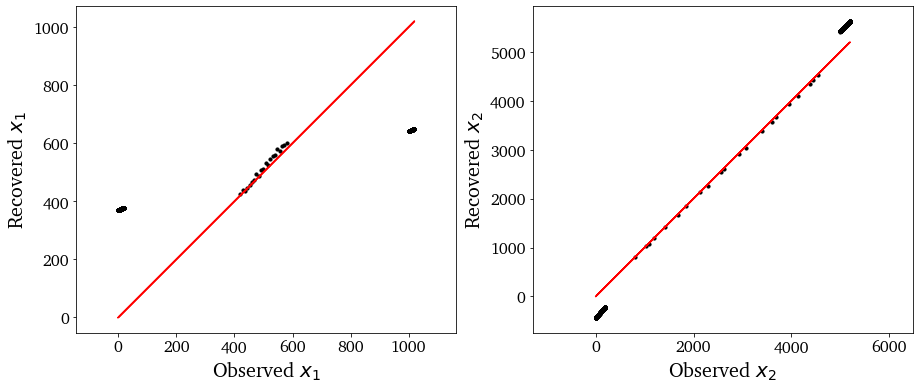

In [11]:
fig = plt.figure(figsize=(15, 6))

figureSubplot = plt.subplot(1,2,1)
plt.scatter(x1,Dataset_weighted_approx[:,0], c='k', s=10)
plt.plot(x1, x1, c='r')
plt.axis('equal')
plt.xlabel('Observed $x_1$', fontsize=20)
plt.ylabel('Recovered $x_1$', fontsize=20)

figureSubplot = plt.subplot(1,2,2)
plt.scatter(x2,Dataset_weighted_approx[:,1], c='k', s=10)
plt.plot(x2, x2, c='r')
plt.axis('equal')
plt.xlabel('Observed $x_2$', fontsize=20)
plt.ylabel('Recovered $x_2$', fontsize=20)

## Multi-variable case

In [12]:
%time W_c = kernd.multi_variable_observation_weights(Dataset_scaled)

CPU times: user 30.5 s, sys: 793 ms, total: 31.2 s
Wall time: 31.4 s


Multiply every observation by a corresponding weight from $W_c$:

In [13]:
Dataset_weighted = np.multiply(Dataset_scaled, W_c)

Perform PCA on a kernel density weighted data set and approximate it with 1 PC:

In [14]:
# Perform PCA:
q = 1

pca = PCA()
pca.fit(Dataset_weighted)
scores = pca.transform(Dataset_weighted)
PCs_weighted = pca.components_

Dataset_weighted_projected = np.dot(Dataset_scaled, PCs_weighted[:q,:].T)
Dataset_weighted_approx = np.dot(Dataset_weighted_projected[:,:q], PCs_weighted[:q,:]) * Dataset_scale + Dataset_mean

Text(0, 0.5, 'Approximated $x_2$')

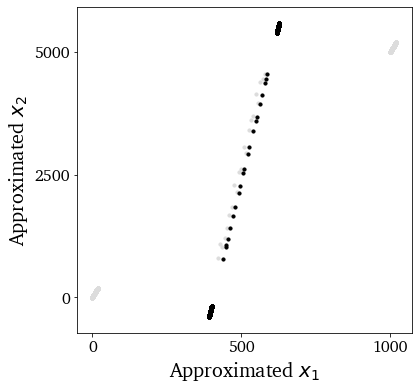

In [15]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(x1, x2, c='gainsboro', s=10)
plt.scatter(Dataset_weighted_approx[:,0],Dataset_weighted_approx[:,1], c='k', s=10)
plt.xticks([0, 500, 1000])
plt.yticks([0, 2500, 5000])
plt.xlabel('Approximated $x_1$', fontsize=20)
plt.ylabel('Approximated $x_2$', fontsize=20)

Parity plots:

Text(0, 0.5, 'Recovered $x_2$')

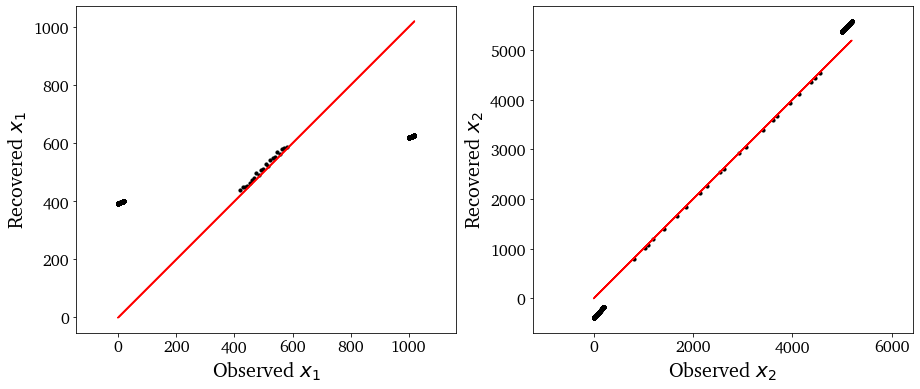

In [16]:
fig = plt.figure(figsize=(15, 6))

figureSubplot = plt.subplot(1,2,1)
plt.scatter(x1,Dataset_weighted_approx[:,0], c='k', s=10)
plt.plot(x1, x1, c='r')
plt.axis('equal')
plt.xlabel('Observed $x_1$', fontsize=20)
plt.ylabel('Recovered $x_1$', fontsize=20)

figureSubplot = plt.subplot(1,2,2)
plt.scatter(x2,Dataset_weighted_approx[:,1], c='k', s=10)
plt.plot(x2, x2, c='r')
plt.axis('equal')
plt.xlabel('Observed $x_2$', fontsize=20)
plt.ylabel('Recovered $x_2$', fontsize=20)